In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_dir_path = "/kaggle/input/face-expression-recognition-dataset/images/train"
valid_dir_path = "/kaggle/input/face-expression-recognition-dataset/images/validation"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir_path,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale'
)

validation_generator = valid_datagen.flow_from_directory(
    directory=valid_dir_path,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 23060 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [3]:
def resnet_block(x, filters, stride=1):
    residual = x

    x = Conv2D(filters, kernel_size=3, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # x = Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(0.01))(x)
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1 or residual.shape[3] != filters:
        residual = Conv2D(filters, kernel_size=1, strides=stride)(residual)
        residual = BatchNormalization()(residual)

    x = Add()([x, residual])
    x = ReLU()(x)

    return x

In [4]:
input_shape = (48, 48, 1)
inputs = Input(shape=input_shape)

x = Conv2D(64, kernel_size=3, strides=1, padding='same')(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)

x = resnet_block(x, filters=64, stride=1)
x = resnet_block(x, filters=64, stride=1)

x = resnet_block(x, filters=128, stride=2)
x = resnet_block(x, filters=128, stride=1)

x = resnet_block(x, filters=256, stride=2)
x = resnet_block(x, filters=256, stride=1)

x = resnet_block(x, filters=512, stride=2)
x = resnet_block(x, filters=512, stride=1)

x = GlobalAveragePooling2D()(x)
x = Dense(7, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 64)   640         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 48, 48, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 48, 48, 64)   0           ['batch_normalization[0][0]']

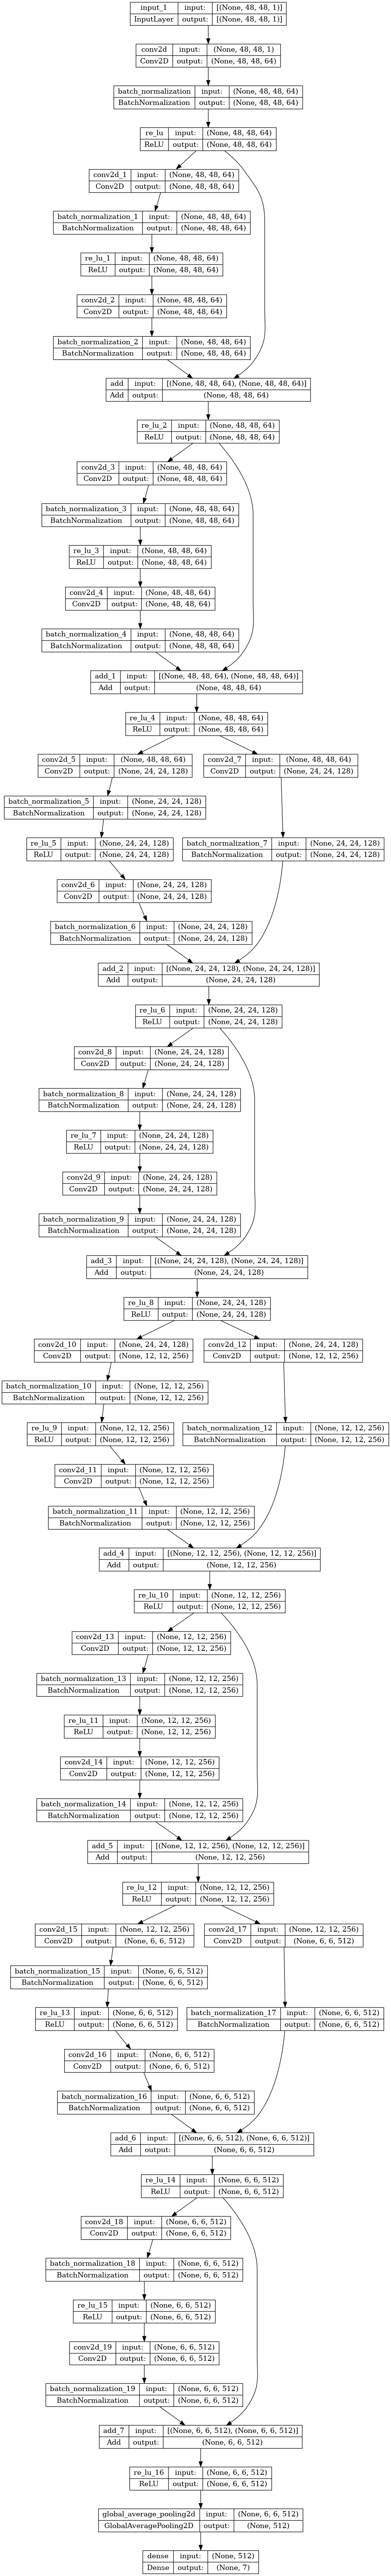

In [6]:
import graphviz
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='/kaggle/working/model.png', show_shapes=True)

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 64)   640         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 48, 48, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 48, 48, 64)   0           ['batch_normalization[0][0]']

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpoint = ModelCheckpoint('/kaggle/working/best_model_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.001)

# opt = SGD(lr=0.01, momentum=0.9)  # Set the SGD optimizer with a learning rate of 0.01 and a momentum of 0.9
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=10, validation_data = validation_generator, callbacks = [checkpoint, reduce_lr])

Epoch 1/10
361/361 [==============================] - ETA: 0s - loss: 1.8221 - accuracy: 0.2799
Epoch 1: val_accuracy improved from -inf to 0.25828, saving model to /kaggle/working/best_model_weights.h5
361/361 [==============================] - 155s 377ms/step - loss: 1.8221 - accuracy: 0.2799 - val_loss: 3.1483 - val_accuracy: 0.2583 - lr: 0.0010
Epoch 2/10
361/361 [==============================] - ETA: 0s - loss: 1.5125 - accuracy: 0.4149
Epoch 2: val_accuracy improved from 0.25828 to 0.29989, saving model to /kaggle/working/best_model_weights.h5
361/361 [==============================] - 40s 110ms/step - loss: 1.5125 - accuracy: 0.4149 - val_loss: 2.0296 - val_accuracy: 0.2999 - lr: 0.0010
Epoch 3/10
361/361 [==============================] - ETA: 0s - loss: 1.3346 - accuracy: 0.4872
Epoch 3: val_accuracy improved from 0.29989 to 0.48528, saving model to /kaggle/working/best_model_weights.h5
361/361 [==============================] - 39s 108ms/step - loss: 1.3346 - accuracy: 0.487

In [15]:
history = model.fit(train_generator, epochs=20, validation_data = validation_generator, callbacks = [checkpoint])

Epoch 1/20
361/361 [==============================] - ETA: 0s - loss: 0.1152 - accuracy: 0.9595
Epoch 1: val_accuracy did not improve from 0.66530
361/361 [==============================] - 59s 164ms/step - loss: 0.1152 - accuracy: 0.9595 - val_loss: 2.0320 - val_accuracy: 0.6470
Epoch 2/20
361/361 [==============================] - ETA: 0s - loss: 0.1185 - accuracy: 0.9587
Epoch 2: val_accuracy did not improve from 0.66530
361/361 [==============================] - 60s 166ms/step - loss: 0.1185 - accuracy: 0.9587 - val_loss: 1.9614 - val_accuracy: 0.6568
Epoch 3/20
361/361 [==============================] - ETA: 0s - loss: 0.1154 - accuracy: 0.9597
Epoch 3: val_accuracy did not improve from 0.66530
361/361 [==============================] - 62s 171ms/step - loss: 0.1154 - accuracy: 0.9597 - val_loss: 2.0089 - val_accuracy: 0.6500
Epoch 4/20
361/361 [==============================] - ETA: 0s - loss: 0.1028 - accuracy: 0.9643
Epoch 4: val_accuracy did not improve from 0.66530
361/361 [=

In [6]:
model.load_weights('/kaggle/working/best_model_weights.h5')

In [7]:
model.save('/kaggle/working/resnet_model.h5')

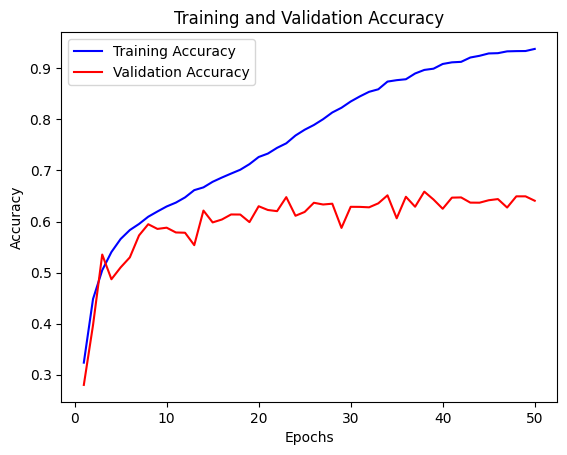

In [9]:
import matplotlib.pyplot as plt
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the accuracy curve
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/kaggle/working/accuracy_plot.png')

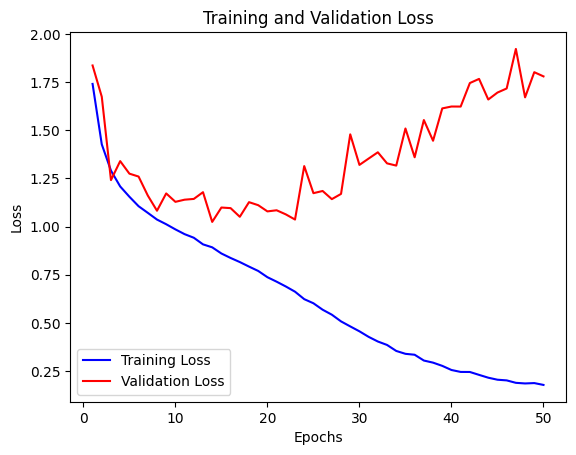

In [10]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss curve
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/loss_plot.png')

In [12]:
for layer in model.layers[:-5]: 
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_fine_tuning = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks = [reduce_lr]
)

Epoch 1/20
361/361 [==============================] - 72s 165ms/step - loss: 0.2802 - accuracy: 0.8993 - val_loss: 1.4492 - val_accuracy: 0.6558 - lr: 0.0010
Epoch 2/20
361/361 [==============================] - 59s 163ms/step - loss: 0.2637 - accuracy: 0.9059 - val_loss: 1.7416 - val_accuracy: 0.6228 - lr: 0.0010
Epoch 3/20
361/361 [==============================] - 60s 166ms/step - loss: 0.2425 - accuracy: 0.9134 - val_loss: 1.5708 - val_accuracy: 0.6428 - lr: 0.0010
Epoch 4/20
361/361 [==============================] - 63s 174ms/step - loss: 0.2378 - accuracy: 0.9169 - val_loss: 1.7232 - val_accuracy: 0.6214 - lr: 0.0010
Epoch 5/20
361/361 [==============================] - 64s 176ms/step - loss: 0.2320 - accuracy: 0.9184 - val_loss: 1.7453 - val_accuracy: 0.6306 - lr: 0.0010
Epoch 6/20
361/361 [==============================] - 62s 171ms/step - loss: 0.2217 - accuracy: 0.9213 - val_loss: 1.6857 - val_accuracy: 0.6439 - lr: 0.0010
Epoch 7/20
361/361 [==============================] 